## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-05-08 15:59:29.115642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 15:59:29.115666: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Create a dataset

In [2]:
import pathlib

data_dir = "/home/ghazal/Desktop/final_project/dataset/data/natural_images"

In [3]:
batch_size = 32
img_height = 96
img_width = 96

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale',
  )

Found 6682 files belonging to 2 classes.
Using 5346 files for training.


2022-05-08 15:59:31.647541: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-08 15:59:31.647584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ghazal): /proc/driver/nvidia/version does not exist
2022-05-08 15:59:31.648060: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6682 files belonging to 2 classes.
Using 1336 files for validation.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/ghazal/Desktop/final_project/dataset/data/test",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=1)

Found 217 files belonging to 2 classes.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [7]:
class_names = train_ds.class_names
print(class_names)

['motorbike', 'other']


## Visualize the data

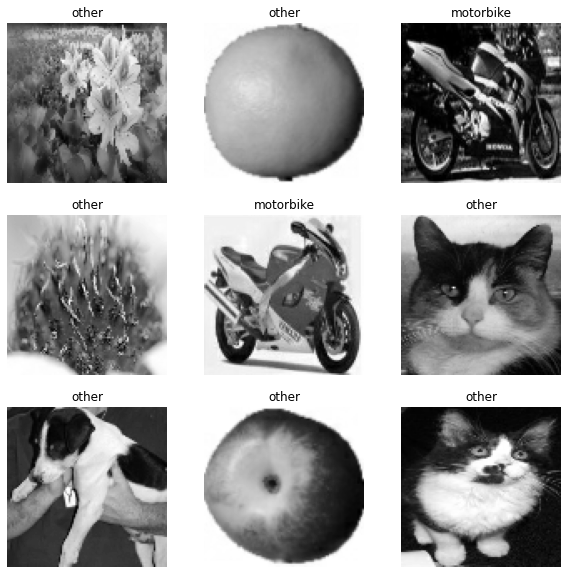

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 1)
(32,)


## Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))


In [13]:
normalized_ds_valid = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds_valid))

2022-05-08 15:59:38.126073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
normalized_ds_test = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds_test))

## Data augmentation

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [17]:
normalized_ds_aug = normalized_ds.map(lambda x, y: (data_augmentation(x), y))
image_batch, labels_batch = next(iter(normalized_ds_aug))

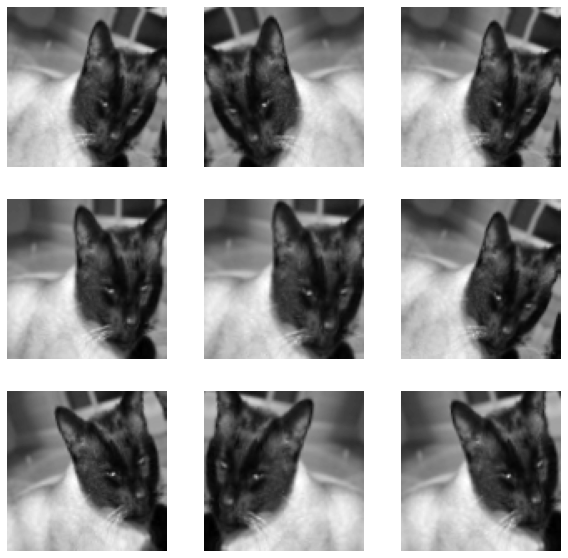

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

## Models


In [19]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [23]:
num_classes=2
from tensorflow.keras.regularizers import l2

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('swish'),

  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('swish'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='swish'),
  layers.Dense(num_classes)
])

In [51]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('swish'),

  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('swish'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='swish'),
  layers.Dense(num_classes)
])

In [134]:
model3 = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(96, 96, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('relu'),

  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [69]:
num_classes=2
from tensorflow.keras.regularizers import l2

model1_new = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(4, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='swish'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('swish'),

  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('swish'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='softmax'),
  layers.Dense(num_classes)
])

In [30]:
num_classes=2
from tensorflow.keras.regularizers import l2
model4 = Sequential([
  #layers.MaxPooling2D(input_shape=(96, 96, 1)),
  layers.Conv2D(2, 3, padding='same', activation='relu', input_shape=(96, 96, 1), kernel_regularizer=l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('relu'),
  layers.Conv2D(32,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('relu'),

  layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('relu'),
  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  #layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('relu'),
  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(),
  #layers.Activation('relu'),
  #layers.MaxPooling2D(),
  layers.DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.Activation('relu'),
  layers.Conv2D(64,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(50, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile and train the models

In [31]:

opt = keras.optimizers.Adam()
model4.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 96, 96, 2)         20        
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 2)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 4)         76        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 16)        592       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 12, 16)      

In [32]:
epochs = 15
history4 = model4.fit(
  normalized_ds_aug,
  validation_data=normalized_ds_valid,
  epochs=epochs
)

Epoch 1/15
168/168 [==============================] - 10s 51ms/step - loss: 0.2840 - accuracy: 0.8992 - val_loss: 0.6651 - val_accuracy: 0.8960
Epoch 2/15
168/168 [==============================] - 9s 52ms/step - loss: 0.1898 - accuracy: 0.9364 - val_loss: 0.5699 - val_accuracy: 0.8960
Epoch 3/15
168/168 [==============================] - 9s 52ms/step - loss: 0.1519 - accuracy: 0.9547 - val_loss: 0.2589 - val_accuracy: 0.9064
Epoch 4/15
168/168 [==============================] - 9s 52ms/step - loss: 0.1400 - accuracy: 0.9581 - val_loss: 0.1090 - val_accuracy: 0.9790
Epoch 5/15
168/168 [==============================] - 9s 52ms/step - loss: 0.1375 - accuracy: 0.9607 - val_loss: 0.2018 - val_accuracy: 0.9184
Epoch 6/15
168/168 [==============================] - 9s 52ms/step - loss: 0.1232 - accuracy: 0.9667 - val_loss: 0.0988 - val_accuracy: 0.9738
Epoch 7/15
168/168 [==============================] - 9s 51ms/step - loss: 0.1197 - accuracy: 0.9688 - val_loss: 0.1188 - val_accuracy: 0.964

In [70]:
model1_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model1_new.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 96, 96, 1)         0         
                                                                 
 rescaling_5 (Rescaling)     (None, 96, 96, 1)         0         
                                                                 
 conv2d_81 (Conv2D)          (None, 96, 96, 4)         40        
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 48, 48, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 48, 48, 8)         296       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 24, 24, 8)        0         
 g2D)                                                

In [71]:
epochs = 15
history5 = model1_new.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
168/168 [==============================] - 9s 48ms/step - loss: 0.5078 - accuracy: 0.8917 - val_loss: 0.5028 - val_accuracy: 0.8960
Epoch 2/15
168/168 [==============================] - 8s 47ms/step - loss: 0.3966 - accuracy: 0.8917 - val_loss: 0.4132 - val_accuracy: 0.8960
Epoch 3/15
168/168 [==============================] - 8s 47ms/step - loss: 0.3582 - accuracy: 0.8917 - val_loss: 0.3480 - val_accuracy: 0.8960
Epoch 4/15
168/168 [==============================] - 8s 48ms/step - loss: 0.3085 - accuracy: 0.8917 - val_loss: 0.2615 - val_accuracy: 0.8960
Epoch 5/15
168/168 [==============================] - 8s 48ms/step - loss: 0.2468 - accuracy: 0.8917 - val_loss: 0.3328 - val_accuracy: 0.8960
Epoch 6/15
168/168 [==============================] - 8s 47ms/step - loss: 0.2114 - accuracy: 0.8917 - val_loss: 0.2391 - val_accuracy: 0.8960
Epoch 7/15
168/168 [==============================] - 8s 48ms/step - loss: 0.1844 - accuracy: 0.8975 - val_loss: 0.1804 - val_accuracy: 0.9648

In [137]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [138]:
model3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 12, 12, 64)     

In [139]:
epochs = 15
history3 = model3.fit(
  normalized_ds_aug,
  validation_data=normalized_ds_valid,
  epochs=epochs
)

Epoch 1/15
168/168 [==============================] - 11s 64ms/step - loss: 0.1637 - accuracy: 0.9506 - val_loss: 0.3204 - val_accuracy: 0.8960
Epoch 2/15
168/168 [==============================] - 11s 64ms/step - loss: 0.0541 - accuracy: 0.9901 - val_loss: 0.2991 - val_accuracy: 0.8960
Epoch 3/15
168/168 [==============================] - 11s 63ms/step - loss: 0.0344 - accuracy: 0.9953 - val_loss: 0.1787 - val_accuracy: 0.9394
Epoch 4/15
168/168 [==============================] - 11s 63ms/step - loss: 0.0267 - accuracy: 0.9968 - val_loss: 0.0646 - val_accuracy: 0.9865
Epoch 5/15
168/168 [==============================] - 11s 63ms/step - loss: 0.0266 - accuracy: 0.9976 - val_loss: 0.0647 - val_accuracy: 0.9835
Epoch 6/15
168/168 [==============================] - 11s 64ms/step - loss: 0.0247 - accuracy: 0.9981 - val_loss: 0.0409 - val_accuracy: 0.9918
Epoch 7/15
168/168 [==============================] - 11s 63ms/step - loss: 0.0198 - accuracy: 0.9994 - val_loss: 0.0279 - val_accuracy:

In [53]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 1)         0         
                                                                 
 rescaling_8 (Rescaling)     (None, 96, 96, 1)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                 

In [55]:
epochs = 15
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
168/168 [==============================] - 18s 99ms/step - loss: 0.1743 - accuracy: 0.9364 - val_loss: 0.3719 - val_accuracy: 0.9581
Epoch 2/15
168/168 [==============================] - 16s 96ms/step - loss: 0.1088 - accuracy: 0.9609 - val_loss: 0.2221 - val_accuracy: 0.9603
Epoch 3/15
168/168 [==============================] - 16s 97ms/step - loss: 0.0967 - accuracy: 0.9660 - val_loss: 0.2222 - val_accuracy: 0.9476
Epoch 4/15
168/168 [==============================] - 16s 97ms/step - loss: 0.0767 - accuracy: 0.9747 - val_loss: 0.2033 - val_accuracy: 0.9371
Epoch 5/15
168/168 [==============================] - 16s 96ms/step - loss: 0.0750 - accuracy: 0.9781 - val_loss: 0.0455 - val_accuracy: 0.9880
Epoch 6/15
168/168 [==============================] - 16s 95ms/step - loss: 0.0598 - accuracy: 0.9819 - val_loss: 0.0708 - val_accuracy: 0.9753
Epoch 7/15
168/168 [==============================] - 16s 96ms/step - loss: 0.0557 - accuracy: 0.9817 - val_loss: 0.2337 - val_accuracy:

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 1)         0         
                                                                 
 rescaling_7 (Rescaling)     (None, 96, 96, 1)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                 

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
168/168 [==============================] - 18s 100ms/step - loss: 0.1718 - accuracy: 0.9343 - val_loss: 0.2555 - val_accuracy: 0.9162
Epoch 2/15
168/168 [==============================] - 17s 102ms/step - loss: 0.1064 - accuracy: 0.9633 - val_loss: 0.1463 - val_accuracy: 0.9686
Epoch 3/15
168/168 [==============================] - 17s 102ms/step - loss: 0.0897 - accuracy: 0.9688 - val_loss: 0.0779 - val_accuracy: 0.9880
Epoch 4/15
168/168 [==============================] - 17s 101ms/step - loss: 0.0837 - accuracy: 0.9706 - val_loss: 0.0696 - val_accuracy: 0.9775
Epoch 5/15
168/168 [==============================] - 17s 101ms/step - loss: 0.0646 - accuracy: 0.9783 - val_loss: 0.0483 - val_accuracy: 0.9850
Epoch 6/15
168/168 [==============================] - 17s 98ms/step - loss: 0.0490 - accuracy: 0.9839 - val_loss: 0.0726 - val_accuracy: 0.9775
Epoch 7/15
168/168 [==============================] - 17s 99ms/step - loss: 0.0469 - accuracy: 0.9835 - val_loss: 0.0881 - val_accu

## Visualize training results

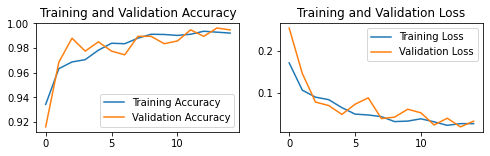

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

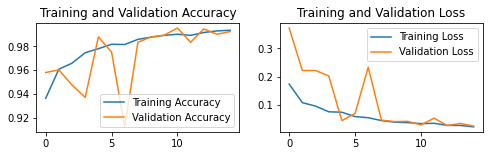

In [56]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

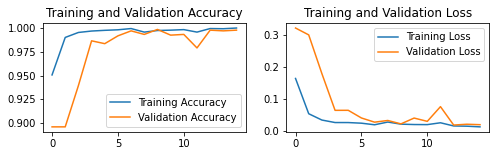

In [140]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

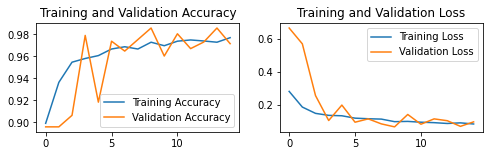

In [33]:
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']

loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc4, label='Training Accuracy')
plt.plot(epochs_range, val_acc4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss4, label='Training Loss')
plt.plot(epochs_range, val_loss4, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

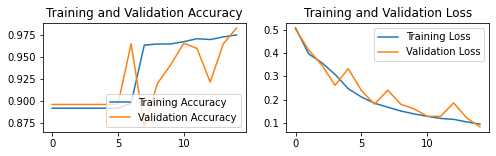

In [72]:
acc5 = history5.history['accuracy']
val_acc5 = history5.history['val_accuracy']

loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc5, label='Training Accuracy')
plt.plot(epochs_range, val_acc5, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss5, label='Training Loss')
plt.plot(epochs_range, val_loss5, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on test data

In [73]:
prediction5 = []
labels5 = []
for x, y in test_ds:
  prediction5.append(np.argmax(model1_new.predict(x)))
  labels5.extend(np.array(y))

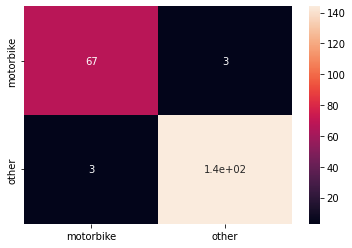

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels_matrix = ["motorbike", "other"]
cf_matrix5 = confusion_matrix(prediction5, labels5)
matrix5 = sns.heatmap(cf_matrix5, annot=True)
matrix5.xaxis.set_ticklabels(['motorbike','other'])
matrix5.yaxis.set_ticklabels(['motorbike','other'])
plt.show()

In [75]:
model1_new.save("best_model1_new.h5", overwrite=False)

In [34]:
prediction4 = []
labels4 = []
for x, y in test_ds:
  prediction4.append(np.argmax(model4.predict(x)))
  labels4.extend(np.array(y))

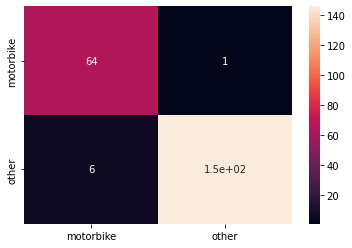

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels_matrix = ["motorbike", "other"]
cf_matrix4 = confusion_matrix(prediction4, labels4)
matrix3 = sns.heatmap(cf_matrix4, annot=True)
matrix3.xaxis.set_ticklabels(['motorbike','other'])
matrix3.yaxis.set_ticklabels(['motorbike','other'])
plt.show()

In [117]:
model4.save("best_model_down2.h5", overwrite=False)

In [141]:
prediction3 = []
labels3 = []
for x, y in test_ds:
  prediction3.append(np.argmax(model3.predict(x)))
  labels3.extend(np.array(y))

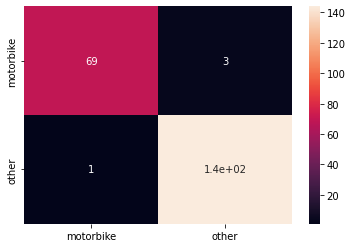

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels_matrix = ["motorbike", "other"]
cf_matrix3 = confusion_matrix(prediction3, labels3)
matrix3 = sns.heatmap(cf_matrix3, annot=True)
matrix3.xaxis.set_ticklabels(['motorbike','other'])
matrix3.yaxis.set_ticklabels(['motorbike','other'])
plt.show()

In [143]:
model3.save("best_model_lighter.h5", overwrite=False)

[TIP] Next time specify overwrite=True!


In [57]:
prediction2 = []
labels2 = []
for x, y in test_ds:
  prediction2.append(np.argmax(model2.predict(x)))
  labels2.extend(np.array(y))

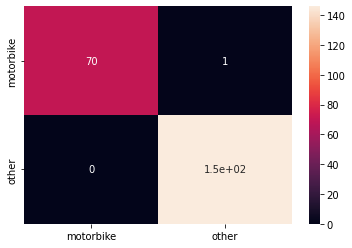

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels_matrix = ["motorbike", "other"]
cf_matrix2 = confusion_matrix(prediction2, labels2)
matrix2 = sns.heatmap(cf_matrix2, annot=True)
matrix2.xaxis.set_ticklabels(['motorbike','other'])
matrix2.yaxis.set_ticklabels(['motorbike','other'])
plt.show()

In [59]:
model2.save("best_model_light.h5", overwrite=False)

In [23]:
prediction = []
labels = []
for x, y in test_ds:
  prediction.append(np.argmax(model.predict(x)))
  labels.extend(np.array(y))


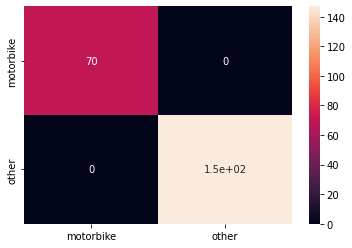

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels_matrix = ["motorbike", "other"]
cf_matrix = confusion_matrix(prediction, labels)
matrix = sns.heatmap(cf_matrix, annot=True)
matrix.xaxis.set_ticklabels(['motorbike','other'])
matrix.yaxis.set_ticklabels(['motorbike','other'])
plt.show()

In [28]:
model.save("best_model.h5", overwrite=False)

## Quantize and Convert to TFLite

In [76]:
converter5 = tf.lite.TFLiteConverter.from_keras_model(model1_new)
converter5.optimizations = [tf.lite.Optimize.DEFAULT]

num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

converter5.optimizations = [tf.lite.Optimize.DEFAULT]
converter5.representative_dataset = representative_dataset_gen
converter5.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter5.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter5.inference_output_type = tf.int8  # or tf.u

tflite_quant_model5 = converter5.convert()

fname = 'model_model1_new.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model5)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model5)} bytes to tflite file")

!xxd -i model_model1_new.tflite >! model_model1_new.c

INFO:tensorflow:Assets written to: /tmp/tmprhg_l68g/assets


INFO:tensorflow:Assets written to: /tmp/tmprhg_l68g/assets
/home/ghazal/.local/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-05-08 14:47:34.708209: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-08 14:47:34.708247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-08 14:47:34.708438: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmprhg_l68g
2022-05-08 14:47:34.713634: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-08 14:47:34.713664: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmprhg_l68g
2022-05-08 14:47:34.735158: I tensorflow/cc/saved_model/loader.cc:

Wrote 319184 / 319184 bytes to tflite file


In [118]:
converter4 = tf.lite.TFLiteConverter.from_keras_model(model4)
converter4.optimizations = [tf.lite.Optimize.DEFAULT]

In [119]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [120]:
converter4.optimizations = [tf.lite.Optimize.DEFAULT]
converter4.representative_dataset = representative_dataset_gen
converter4.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter4.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter4.inference_output_type = tf.int8  # or tf.uint8

In [121]:
tflite_quant_model4 = converter4.convert()

INFO:tensorflow:Assets written to: /tmp/tmpglahbqdl/assets


INFO:tensorflow:Assets written to: /tmp/tmpglahbqdl/assets
/home/ghazal/.local/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-05-08 15:41:43.114126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-08 15:41:43.114162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-08 15:41:43.114353: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpglahbqdl
2022-05-08 15:41:43.120324: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-08 15:41:43.120355: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpglahbqdl
2022-05-08 15:41:43.140971: I tensorflow/cc/saved_model/loader.cc:

In [122]:
fname = 'model_lighter_down2.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model4)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model4)} bytes to tflite file")

Wrote 38920 / 38920 bytes to tflite file


In [123]:
!xxd -i model_lighter_down2.tflite >! model_lighter_down2.c

In [144]:
converter3 = tf.lite.TFLiteConverter.from_keras_model(model3)
converter3.optimizations = [tf.lite.Optimize.DEFAULT]

In [145]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [146]:
converter3.optimizations = [tf.lite.Optimize.DEFAULT]
converter3.representative_dataset = representative_dataset_gen
converter3.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter3.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter3.inference_output_type = tf.int8  # or tf.uint8

In [147]:
tflite_quant_model3 = converter3.convert()

INFO:tensorflow:Assets written to: /tmp/tmps2bfrwzj/assets


INFO:tensorflow:Assets written to: /tmp/tmps2bfrwzj/assets
/home/ghazal/.local/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-05-04 20:21:58.020602: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-04 20:21:58.020688: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-04 20:21:58.020962: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmps2bfrwzj
2022-05-04 20:21:58.024542: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-04 20:21:58.024574: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmps2bfrwzj
2022-05-04 20:21:58.035498: I tensorflow/cc/saved_model/loader.cc:

In [149]:
fname = 'model_lighter.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model3)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model3)} bytes to tflite file")

Wrote 84472 / 84472 bytes to tflite file


In [87]:
!xxd -i model_lighter.tflite >! model_lighter.cc

In [60]:
converter2 = tf.lite.TFLiteConverter.from_keras_model(model2)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]

In [61]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [62]:
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset_gen
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter2.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter2.inference_output_type = tf.int8  # or tf.uint8

In [63]:
tflite_quant_model2 = converter2.convert()

INFO:tensorflow:Assets written to: /tmp/tmp_y6j2epr/assets


INFO:tensorflow:Assets written to: /tmp/tmp_y6j2epr/assets
/home/ghazal/.local/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-05-04 19:23:39.202692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-04 19:23:39.202730: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-04 19:23:39.202919: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp_y6j2epr
2022-05-04 19:23:39.208178: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-04 19:23:39.208207: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp_y6j2epr
2022-05-04 19:23:39.230109: I tensorflow/cc/saved_model/loader.cc:

In [64]:
fname = 'model_light.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model2)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model2)} bytes to tflite file")

Wrote 190664 / 190664 bytes to tflite file


In [66]:
!xxd -i model_light.tflite >! model_light.cc

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [30]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [31]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [32]:
tflite_quant_model = converter.convert()

2022-05-04 16:33:17.600534: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmponteinuy/assets


INFO:tensorflow:Assets written to: /tmp/tmponteinuy/assets
/home/ghazal/.local/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-05-04 16:33:20.774360: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-04 16:33:20.774389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-04 16:33:20.775294: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmponteinuy
2022-05-04 16:33:20.780903: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-04 16:33:20.780937: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmponteinuy
2022-05-04 16:33:20.802671: I tensorflow/cc/saved_model/loader.cc:

In [33]:
fname = 'model.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 338424 / 338424 bytes to tflite file


In [35]:
!xxd -i model.tflite >! model.cc